In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW
import time
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Veri setini yükleme
data = pd.read_csv('0206_veriler.csv')

# Veri setini inceleme
print(data.head())
print(data.describe())

# Veri setini eğitim ve test kümelerine ayırma
X = data['Twitler']
y = data['Durum']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


                                             Twitler  Durum
0  a101 6 nisan firsatlari\n\nucuzkenaldim \n\nre...      1
1                                         trendyol        1
2                            alisverislerime devam        1
3  kargolarimi bana ulastirmak icin defalarca ara...      1
4              favorilerimin hepsini almak isterdim       1
            Durum
count  386.000000
mean     0.500000
std      0.500649
min      0.000000
25%      0.000000
50%      0.500000
75%      1.000000
max      1.000000


In [3]:
# ELECTRA tokenizer'ını oluşturma
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator', do_lower_case=True)

# Veri setini tokenleme
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

In [4]:
# PyTorch tensörlerine dönüştürme
train_inputs = torch.tensor(train_encodings['input_ids'])
train_labels = torch.tensor(list(y_train))
train_masks = torch.tensor(train_encodings['attention_mask'])
test_inputs = torch.tensor(test_encodings['input_ids'])
test_labels = torch.tensor(list(y_test))
test_masks = torch.tensor(test_encodings['attention_mask'])

In [5]:
# GPU kullanımı için tensörleri taşıma
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_inputs = train_inputs.to(device)
train_labels = train_labels.to(device)
train_masks = train_masks.to(device)
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)
test_masks = test_masks.to(device)

In [6]:
# ELECTRA modelini yükleme
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2)
model.to(device)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.o

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [7]:
# Optimizer ve öğrenme oranını belirleme
optimizer = AdamW(model.parameters(), lr=1e-5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

num_epochs = 10
batch_size = 16

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    start_time = time.time()

    # Batch işleme
    for i in range(0, len(train_inputs), batch_size):
        optimizer.zero_grad()

        batch_inputs = train_inputs[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        batch_masks = train_masks[i:i+batch_size]

        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss

        train_loss += loss.item()

        # Geriye yayılım ve optimizasyon
        loss.backward()
        optimizer.step()

        # Eğitim doğruluğunu hesaplama
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()

    train_accuracy = train_correct / train_total
    train_loss /= (len(train_inputs) / batch_size)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    # Test zamanını hesapla
    test_start_time = time.time()

    # Test verisi üzerinde doğruluk hesaplama
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for i in range(0, len(test_inputs), batch_size):
            # Batch işleme
            batch_inputs = test_inputs[i:i+batch_size]
            batch_labels = test_labels[i:i+batch_size]
            batch_masks = test_masks[i:i+batch_size]

            outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
            loss = outputs.loss

            test_loss += loss.item()

            logits = outputs.logits
            _, predicted = torch.max(logits, 1)
            test_total += batch_labels.size(0)
            test_correct += (predicted == batch_labels).sum().item()

    test_accuracy = test_correct / test_total
    test_loss /= (len(test_inputs) / batch_size)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

    test_end_time = time.time()
    test_epoch_time = test_end_time - test_start_time

    end_time = time.time()
    epoch_time = end_time - start_time

    # Epoch numarasını, loss değerlerini ve süreleri yazdırma
    print("Epoch:", epoch+1, "Loss:", train_loss, "Train Accuracy:", train_accuracy, "Test Accuracy:", test_accuracy,
          "Epoch Time:", epoch_time, "Test Time:", test_epoch_time)

Epoch: 1 Loss: 0.7239403662743507 Train Accuracy: 0.5064935064935064 Test Accuracy: 0.3717948717948718 Epoch Time: 56.6865668296814 Test Time: 3.400520086288452
Epoch: 2 Loss: 0.7113663097480675 Train Accuracy: 0.5487012987012987 Test Accuracy: 0.41025641025641024 Epoch Time: 53.48373818397522 Test Time: 3.5789010524749756
Epoch: 3 Loss: 0.6901933279904452 Train Accuracy: 0.6168831168831169 Test Accuracy: 0.7051282051282052 Epoch Time: 53.241294860839844 Test Time: 3.776226043701172
Epoch: 4 Loss: 0.6570349792381386 Train Accuracy: 0.6493506493506493 Test Accuracy: 0.782051282051282 Epoch Time: 55.975661277770996 Test Time: 3.7834088802337646
Epoch: 5 Loss: 0.5946595746201354 Train Accuracy: 0.724025974025974 Test Accuracy: 0.7564102564102564 Epoch Time: 56.13337802886963 Test Time: 3.8668529987335205
Epoch: 6 Loss: 0.46959436404240595 Train Accuracy: 0.8344155844155844 Test Accuracy: 0.7564102564102564 Epoch Time: 57.97012686729431 Test Time: 3.898716926574707
Epoch: 7 Loss: 0.3630007

In [9]:
# Değerlendirme metriklerini hesaplama
model.eval()
with torch.no_grad():
    test_outputs = model(input_ids=test_inputs, attention_mask=test_masks)
    test_logits = test_outputs.logits
    test_predictions = torch.argmax(test_logits, dim=1)

accuracy = accuracy_score(list(test_labels.cpu()), list(test_predictions.cpu()))
precision = precision_score(list(test_labels.cpu()), list(test_predictions.cpu()))
recall = recall_score(list(test_labels.cpu()), list(test_predictions.cpu()))
f1 = f1_score(list(test_labels.cpu()), list(test_predictions.cpu()))

# Sonuçları yazdırma
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.5641025641025641
Precision: 0.8571428571428571
Recall: 0.3673469387755102
F1-Score: 0.5142857142857143


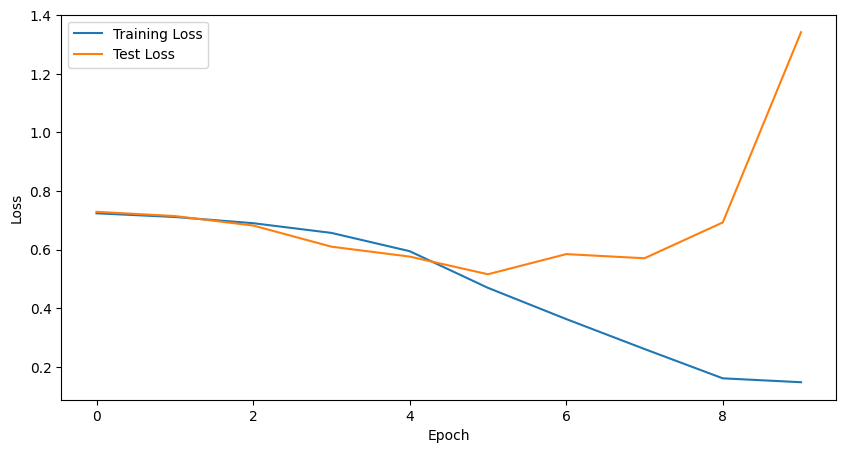

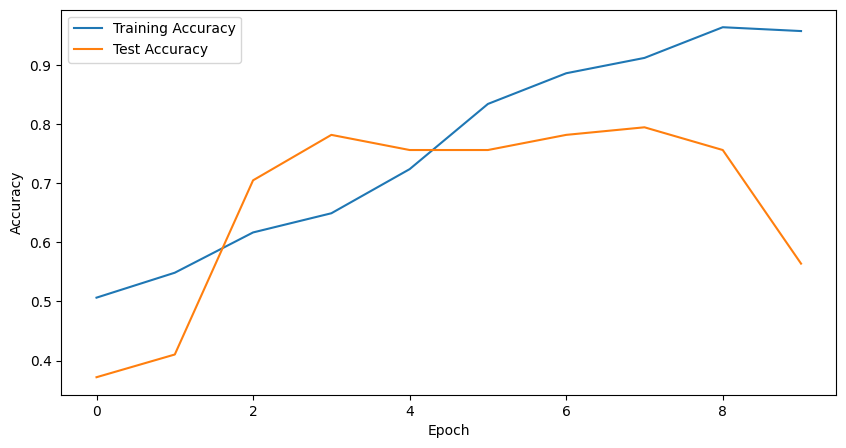

In [10]:
# Eğitim ve test loss değerlerini ve doğruluk değerlerini grafiğe dökme
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()